# Gathering Earthquake Info with Libcomcat

### EQ of the Week, 15 March, 2022

Libcomcat is a python interface for searching the ANSS earthquake catalog. Using this package you can:
- search for earthquakes over a region
- search for earthquake info based on a known ID
- pull origin, moment tensor, DYFI, etc results for an event
- download event related data (ex: Finite-Fault)

### Acquiring Libcomcat:
The easiest way to download is through conda. It is recommended that you create a seperate conda environment. 
```
conda install libcomcat
```
More info about libcomcat and how to download here: https://github.com/usgs/libcomcat#readme

In [23]:
# importing necessary packages
import libcomcat                   
from datetime import datetime
import pandas as pd
import numpy as np


# for visualization
#import matplotlib.pyplot as plt
import pygmt     # <---- unsure how to use pygmt? Check out Utpal's notebook in the EWQ Github repository

### Searching the ComCat catalog for earthquakes

You can search the ANSS earthquake catalog for known events by setting a search region.  The region can either be set as a bounding box, or by selecting a point and defining a radius.  In this example, I am searching for all events over the year 2021 along the Alaskan Peninsula.

In [24]:
from libcomcat.search import  search, get_event_by_id

from libcomcat.dataframes import (get_detail_data_frame, get_dyfi_data_frame,
                                  get_history_data_frame, get_magnitude_data_frame,
                                  get_pager_data_frame, get_phase_dataframe,
                                  get_summary_data_frame)


# search params
search_region     = [-162,-150, 52,58]                 # lonmin, lonmax, latmin, latmax
search_start_time = datetime(2021, 1, 1, 1, 1)         # start of search timeframe
search_end_time   = datetime(2021, 12, 31, 23, 59)     # end of search timeframe

minmagnitude=3                                         # min magnitude (set to limit getting tons of small events)
maxmagnitude=10                                         # max magnitude (set here to be unreasonably high)

earthquakes = search(starttime=search_start_time, endtime=search_end_time,
                   minlatitude=search_region[2], maxlatitude=search_region[3], 
                    minlongitude=search_region[0], maxlongitude=search_region[1],
                     minmagnitude=minmagnitude,maxmagnitude=maxmagnitude)

print('Querey found ',len(earthquakes),' earthquakes!')



Querey found  800  earthquakes!


In [25]:
print(earthquakes[0])

us6000d7y8 2021-01-01 05:28:01.164000 (54.957,-159.261) 17.8 km M3.1


In [26]:
# convert the output to a more usable format:
catalog_df = pd.DataFrame( {'ID':[eq.id for eq in earthquakes],
                            'time':[eq.time for eq in earthquakes],
                            'longitude':[eq.longitude for eq in earthquakes],
                            'latitude':[eq.latitude for eq in earthquakes],
                            'depth':[eq.depth for eq in earthquakes],
                            'magnitude':[eq.magnitude for eq in earthquakes]})


catalog_df.head()

,ID,time,longitude,latitude,depth,magnitude
0,us6000d7y8,2021-01-01 05:28:01.164,-159.2610,54.9570,17.78,3.1
1,ak0211xdy3l,2021-01-01 16:54:36.833,-158.0119,54.6779,15.40,3.6
2,us6000d7ya,2021-01-01 17:16:36.598,-159.6256,54.1865,25.10,3.0
3,us6000d7yc,2021-01-01 20:47:34.322,-161.6394,54.3864,23.57,3.0
4,ak0213cvy4a,2021-01-02 03:04:41.615,-157.9715,55.0406,16.80,3.0


### Plot the results

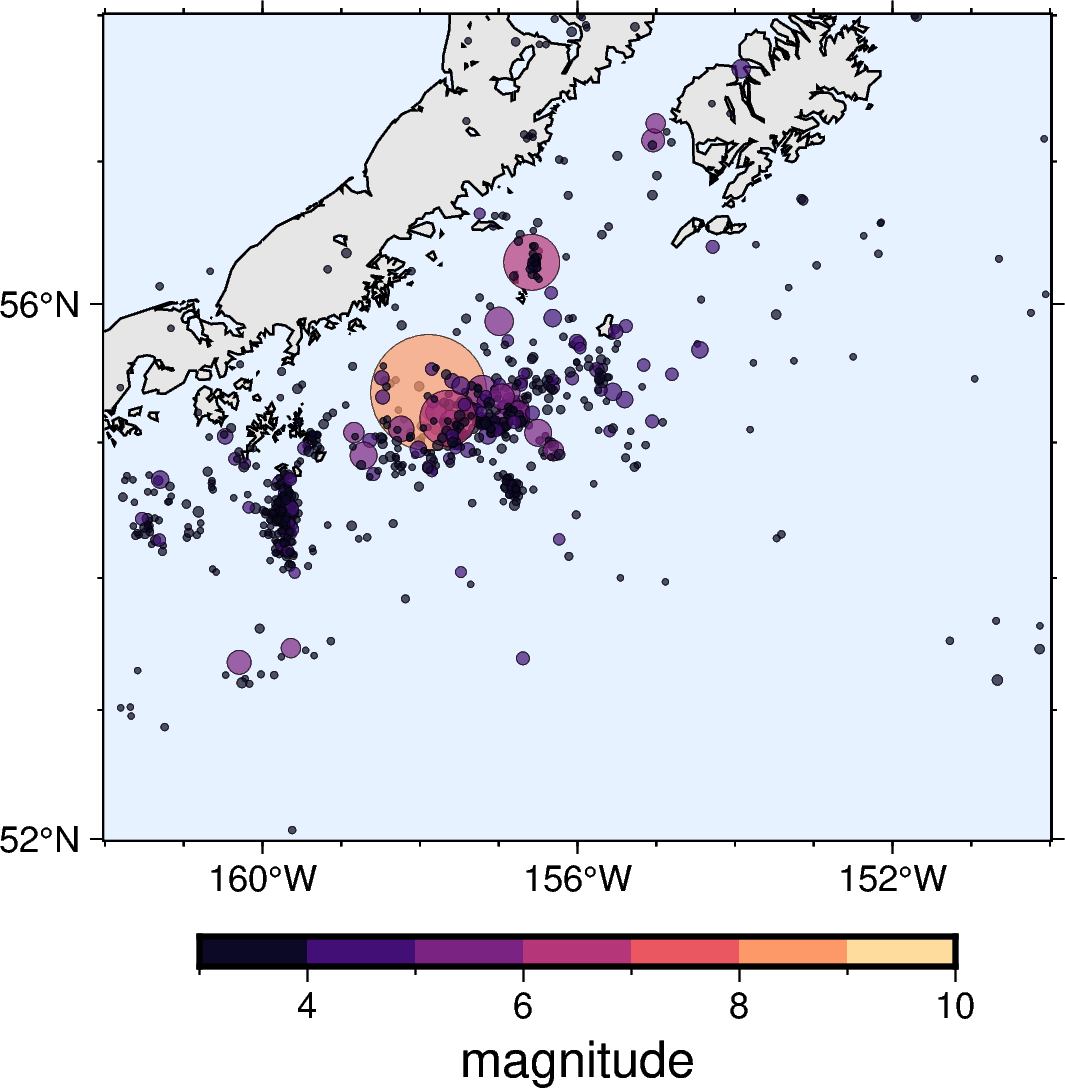

In [27]:
fig = pygmt.Figure()

pygmt.config(MAP_FRAME_TYPE="plain")

fig.basemap(projection="M8c",region=search_region,frame=["a4f1",'WSne'])       # set blank map over search region

fig.coast(shorelines=["1/0.5p","2/0.5p"],land="#e6e6e6", water="#e6f2ff")      # add coast, land, sea colors

pygmt.makecpt(cmap="magma", series=(minmagnitude, maxmagnitude, 1))            # make color scale
fig.plot(x = catalog_df['longitude'],y=catalog_df['latitude'],
         pen='0.1p',size=0.01*(1.75**catalog_df['magnitude']),
         style='cc',color=catalog_df['magnitude'],cmap=True,transparency=30)   # plot catalog as mag-scaled circles

fig.colorbar(frame=["x+lmagnitude"])
fig.show()

### Look at a single (larger) event:
Here I am grabbing the largest event from this catalog. It was the M8.2 Chignik earthquake that occured last summer.

In [28]:
idx = np.argmax(catalog_df['magnitude'])             # get the largest magnitude earthquake in this catalog
event_id =catalog_df['ID'].iloc[idx]


event = get_event_by_id(event_id)
event

ak0219neiszm 2021-07-29 06:15:49.188000 (55.364,-157.888) 35.0 km M8.2

In [29]:

USGS_products, event = get_history_data_frame(event)   # this can take ~10+ seconds for bigger events with more products
USGS_products['Product'].value_counts()                # show what products are available


origin            4
shakemap          3
losspager         2
phase-data        2
moment-tensor     2
finite-fault      2
dyfi              1
ground-failure    1
oaf               1
Name: Product, dtype: int64

### Who felt this earthquake?  
Here, I will grab the did you feel it reports and plot them on a map.  The DYFI data is accessed through the "get_dyfi_data_frame" function

In [30]:

dyfi_df = get_dyfi_data_frame(event)
dyfi_df.head()

,station,lat,lon,distance,intensity,nresp
0,UTM:(10T 0423 5006 1000),45.207825,-123.974148,2669,1.0,1
1,UTM:(10T 0508 5209 1000),47.038955,-122.888110,2616,2.0,1
2,UTM:(2U 0520 5827 1000),52.597135,-170.697338,896,3.1,1
3,UTM:(3U 0398 5970 1000),53.873027,-166.543805,584,2.0,1
4,UTM:(3U 0645 6120 1000),55.209585,-162.713293,308,3.8,1


### Plot DYFI results
Here I set a region near the earthquake and expected affected communities.  You can instead set your view region to be the as big as the furthest responses. Beware, though, sometimes extremely far-field responses dminish map quality.

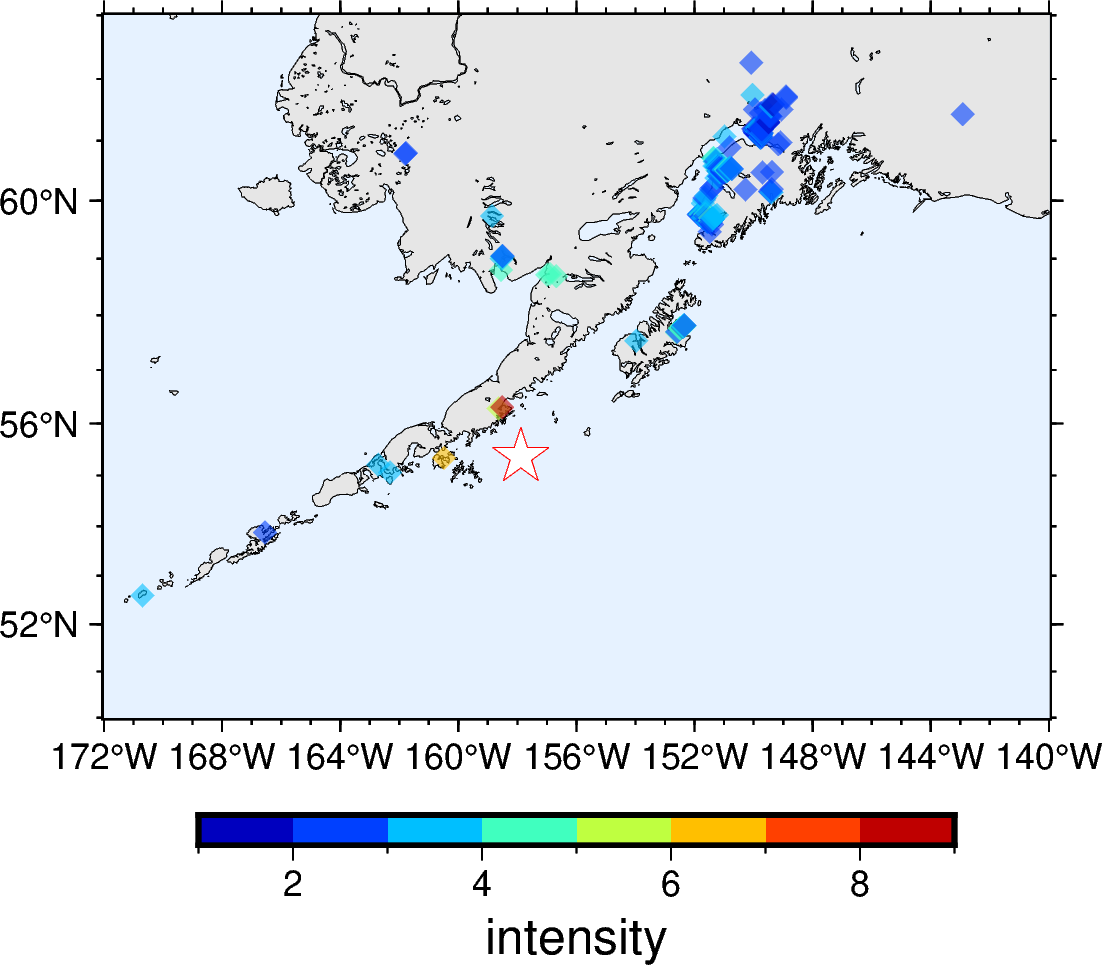

In [31]:
dyfi_region = [-172, -140,50,63]    # I set a region near the earthquake.  


fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")

fig.basemap(projection="M8c",region=dyfi_region,frame=["a4f1",'WSne'])

fig.coast(shorelines=["1/0.1p","2/0.1p"],land="#e6e6e6", water="#e6f2ff")

pygmt.makecpt(cmap="jet", series=(1, 9, 1))

fig.plot(x = dyfi_df['lon'],y = dyfi_df['lat'],color=dyfi_df['intensity'],
         style='d.2c',transparency=40,cmap=True)

fig.plot(x = event.longitude, y = event.latitude, pen='0.1p,red',style='a.5c',color='white')

fig.colorbar(frame=["x+lintensity"])
fig.show()

### Search for and download relevant data

In [32]:
products = event.getProducts('finite-fault', version='preferred')    # get preferred finite-fault info
products[0].contents

['coulomb.inp',
 'properties.json',
 'surface_deformation.disp',
 'basemap.png',
 'shakemap_polygon.txt',
 'basic_inversion.param',
 'FFM.geojson',
 'contents.xml',
 'moment_rate.mr',
 'slip.png',
 'waveplots.zip',
 'moment_rate.png',
 'CMTSOLUTION',
 'complete_inversion.fsp',
 'analysis.html']

In [33]:
filename = './'+event_id+'_finite_fault.param'   # Downloading to this folder
products[0].getContent('basic_inversion.param',filename)

'https://earthquake.usgs.gov/product/finite-fault/ak0219neiszm_2/us/1635193034829/basic_inversion.param'